In [389]:
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import networkx as nx

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

___

Let's first load the dataset 

In [390]:
df_lalonde = pd.read_csv('lalonde.csv')
print("Shape df_lalonde: {}".format(df_lalonde.shape))
df_lalonde.head()

Shape df_lalonde: (614, 11)


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Let's get our dataset separated into 2 subsets: treated and untreated cases. We notice that we have a lot more untreated subjects than treated. 

In [391]:
# Divide dataset into treated and untreated
df_treated = df_lalonde[df_lalonde['treat'] == 1].reset_index()
print("Number of treated subjects: {}".format(df_treated.shape[0]))

df_untreated = df_lalonde[df_lalonde['treat'] == 0].reset_index()
print("Number of untreated subjects: {}".format(df_untreated.shape[0]))

Number of treated subjects: 185
Number of untreated subjects: 429


In [392]:
print("\nDescription real earning in 1978 for treated subjects:")
print(df_treated['re78'].describe())

print("\nDescription real earning in 1978 for untreated subjects:")
print(df_untreated['re78'].describe())


Description real earning in 1978 for treated subjects:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

Description real earning in 1978 for untreated subjects:
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64


Before producing any plots, we take a look at the description of real earnings in 1978 for both subset:

1. If we observe only the **min** and **max** values, we notice that the maximal earning for treated cases is way higher than for untreaded ones. This leads to think the job training is a real plus for people who attended it. 

2. If we observe **mean** and **std** values: Both the standard deviation and average of the values (6349 and 6984) are of the same order for both subset. Nevertheless, the average earning in 1978 for treated cases is lower than for untreated. The standard deviation is higher for our treated subset. Let's just think it is because the range of values is higher (naive approch).
    
    
As we are not that naive, we start to see a contradiction between our two first observations, using basic statistics. However, when we take a look at other features such as the quartiles, we see that:

- the upper quartile is indeed higher for untreated subjects, which meets our observation **1.** above
- the lower quartile is lower for untreated subjects, which tends to join our **2.** observation


Now, let's take a look at our dataset graphically, to better understand what's going on in there.


In order to visualize the distribution of real earnings in '78, we will use discrete intervals of earnings. We define intervals with a range of 2000. We create a new feature in our datasets to caracterize the earning range.

In [393]:
# Get minimum and maximum values of earning in '78 overall dataset
re78_max_overall = np.max(df_lalonde['re78'])
re78_min_overall = np.min(df_lalonde['re78'])

# Define and create intervals and corresponding labels
bins = np.arange(int(re78_min_overall), math.ceil(re78_max_overall) + 2000, 2000)
labels = [str(bins[i]) + "-" + str(bins[i+1]) for i in range(0, len(bins) - 1)]   

# We would like to count the value "0" within the first range (closed intervals)
bins[0] = bins[0] - 1

# Divide by 're78' ranges in a new feature
df_treated['re78_range'] = pd.cut(df_treated['re78'], bins = bins, labels = labels)
df_untreated['re78_range'] = pd.cut(df_untreated['re78'], bins = bins, labels = labels)

Now, let's take look at their distribution

In [394]:

def barplot_distrib(data, labels, title, ax):
    """Function to display the distribution of a pandas Series
    return: values used for the y axis"""
    
    x = data.value_counts().keys()
    y = 100 * data.value_counts() / data.shape[0]
    
    sns.barplot(x = x,  y = y, order = labels, ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_title(title, fontsize = 18)
    return y

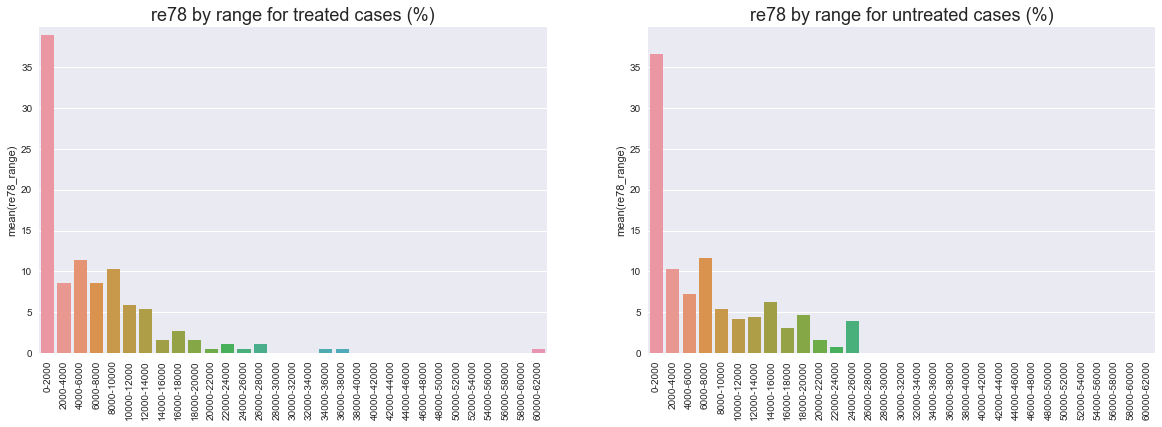

In [395]:
# Plot repartition
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,6))
y_treated = barplot_distrib(df_treated['re78_range'], labels, 're78 by range for treated cases (%)', ax = ax[0])
y_untreated = barplot_distrib(df_untreated['re78_range'], labels, 're78 by range for untreated cases (%)', ax = ax[1])

# Set same y axis for both figure
ax[0].set(ylim=(0, np.max([y_treated, y_untreated])+1));
ax[1].set(ylim=(0, np.max([y_treated, y_untreated])+1));

We have divided the earning in 1978 in ranges of 2000. We observe for both treated and untreated datasets, the repartition of the subjects within those categories. What we see is that earnings for the treated subset can be way higher than for the untreated cases. However, we cannot say that the overall earning is higher for treated subjects. 
Indeed, the percentage of low earning (0-2000) for treated cases is higher than for untreated. This goes against what a naive analyst could think by looking at maximum earnings.

What we understand from this distribution is that very high earnings in the subset of people who attended the formation are indeed outliers. We can confirm that looking at the barplot below.

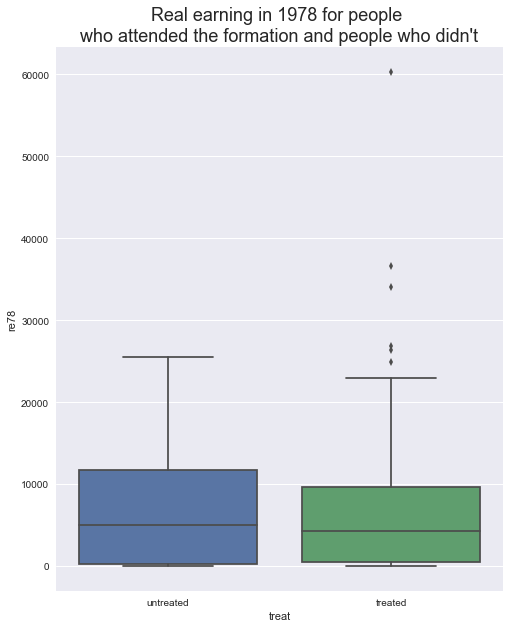

In [396]:
# Display barplot of real earning in '78
fig, ax = plt.subplots(figsize = (8,10))
ax = sns.boxplot(x="treat", y="re78", data=df_lalonde)
ax.set_xticklabels(["untreated", "treated"]);
ax.set_title('Real earning in 1978 for people \nwho attended the formation and people who didn\'t', fontsize = 18);

**Indeed, we understand from this boxplots that very high earnings in the treated subset are indeed outliers.**


___


#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

___

According to what we see above, looking at our data graphically gives a much better first impression than looking at partially at some features. Let's take a look at the other fetures this way.

For each of them, we are going to:
1. Observe minima, maxima, average et standard deviation. Even if those are not robust statistics.
2. Observe 

- **Race** 

The race of a subject is available by combination of the features *black* and *hispan*. We consider that a subject is *white* if he is neither *black* nor *hispan*. We add a new column to our dataset, that allows to know the race of a subject only by looking at this specific column. (Up to now, we had to check both *hispan* and *black* features. 

We define the `race` as follow:

|**race**|**value**|
|---|---|---|
|Black|0|
|Hispan|1|
|White|2|



In [397]:
# Fill race feature for each subject of our initial dataset
for ind in range(df_lalonde.shape[0]):
    if df_lalonde.loc[ind, 'black'] == 1 and df_lalonde.loc[ind, 'hispan'] == 0:
        df_lalonde.loc[ind, 'race'] = int(0)
    elif df_lalonde.loc[ind, 'black'] == 0 and df_lalonde.loc[ind, 'hispan'] == 1:
        df_lalonde.loc[ind, 'race'] = int(1)
    else:
        df_lalonde.loc[ind, 'race'] = int(2)
        
df_lalonde.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.0
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1.0
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.0
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.0
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.0


We also get those 3 subset into separate dataframe

In [398]:
# Divide dataset into black, hispan and white
df_black = df_lalonde[df_lalonde['race'] == 0]
print("Number of black subjects: {}".format(df_black.shape[0]))

df_hispan = df_lalonde[df_lalonde['race'] == 1]
print("Number of hispanic subjects: {}".format(df_hispan.shape[0]))

df_white = df_lalonde[df_lalonde['race'] == 2]
print("Number of white subjects: {}".format(df_white.shape[0]))

Number of black subjects: 243
Number of hispanic subjects: 72
Number of white subjects: 299


In [399]:
print("\nDescription real earning in 1978 for black subjects:")
print(df_black['re78'].describe())

print("\nDescription real earning in 1978 for hispanic subjects:")
print(df_hispan['re78'].describe())

print("\nDescription real earning in 1978 for white subjects:")
print(df_white['re78'].describe())


Description real earning in 1978 for black subjects:
count      243.000000
mean      5677.014655
std       7518.183805
min          0.000000
25%          0.000000
50%       2820.980000
75%       8983.838500
max      60307.930000
Name: re78, dtype: float64

Description real earning in 1978 for hispanic subjects:
count       72.000000
mean      7106.696146
std       7032.610243
min          0.000000
25%       1345.559750
50%       5417.346000
75%       9965.408000
max      26817.600000
Name: re78, dtype: float64

Description real earning in 1978 for white subjects:
count      299.000000
mean      7624.092605
std       7442.468534
min          0.000000
25%        857.820300
50%       5748.356000
75%      12653.770000
max      25564.670000
Name: re78, dtype: float64


As well as in the first question, a naive analysis leads us to contradictory conclusions. 
We observe that black subjects can earn a lot more than others. However, their average of real earnings in 1978,is the lower overall the 3 subsets. 


In [400]:
# Divide by re78 ranges in a new feature
df_black['re78_range'] = pd.cut(df_black['re78'], bins = bins, labels = labels)
df_hispan['re78_range'] = pd.cut(df_hispan['re78'], bins = bins, labels = labels)
df_white['re78_range'] = pd.cut(df_white['re78'], bins = bins, labels = labels)

Let's visualize the distribution of real earnings in 1978 for each race and a boxplot visualization.

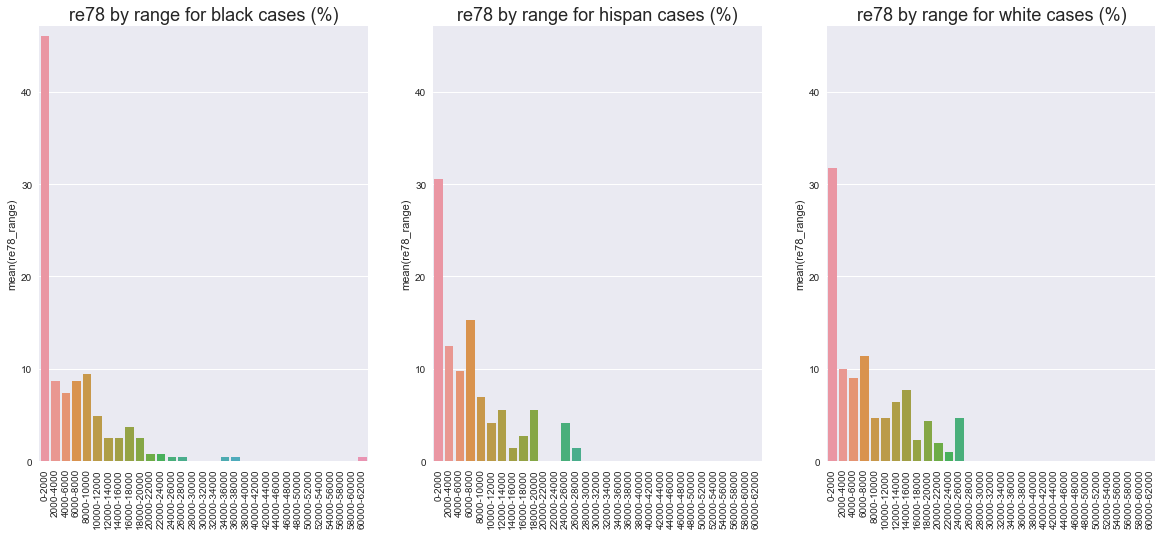

In [401]:
# Plot repartition
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20,8))
y_black = barplot_distrib(df_black['re78_range'], labels, 're78 by range for black cases (%)', ax = ax[0])
y_hispan = barplot_distrib(df_hispan['re78_range'], labels, 're78 by range for hispan cases (%)', ax = ax[1])
y_white = barplot_distrib(df_white['re78_range'], labels, 're78 by range for white cases (%)', ax = ax[2])


ax[0].set(ylim=(0, np.max([y_black, y_hispan, y_white])+1));
ax[1].set(ylim=(0, np.max([y_black, y_hispan, y_white])+1));
ax[2].set(ylim=(0, np.max([y_black, y_hispan, y_white])+1));

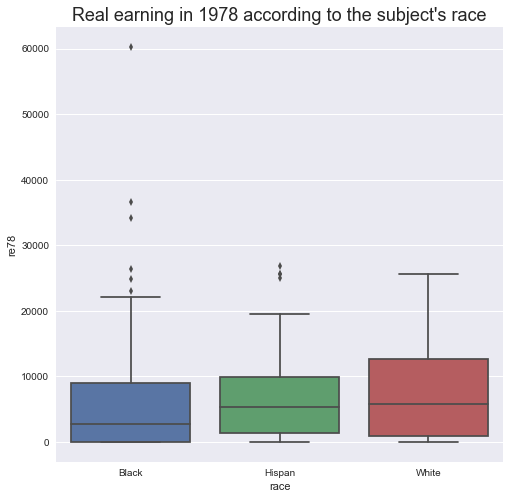

In [402]:
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.boxplot(x="race", y="re78", data=df_lalonde)
ax.set_xticklabels(["Black", "Hispan", "White"])
ax.set_title('Real earning in 1978 according to the subject\'s race', fontsize = 18);

**According to this boxplot, we first see that white subjects earn more in average. However, some Black and Hispan subjects earn way more than White ones. Looking at the lower and upper quartile, we understand that black people tend to earn less, even if they have outliers that earn a lot.**


**Also,we should keep in mind the repartition in those 3 subsets. We have way less hispanic people who took part in this study.**

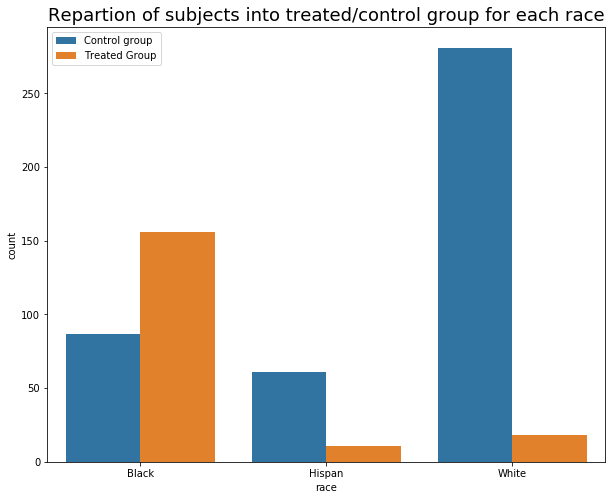

In [46]:
fig, ax = plt.subplots(1, 1,figsize = (10, 8))
sns.countplot(x = 'race', hue = 'treat', data = df_lalonde, ax = ax, order = [0,1,2])
ax.set_xticklabels(["Black", "Hispan","White"])
ax.legend(["Control group", "Treated Group"])
ax.set_title("Repartion of subjects into treated/control group for each race", fontsize = 18);

**We see that distribution of "races" into the two groups are really not the same. Proportion of black people into treated in group is huge. Thus, this results need to be taken lightly as white race is not displayed here (obtained when hispanic=black=0)**

- **married**

In [404]:
# Divide dataset into married and not married
df_unmarried = df_lalonde[df_lalonde['married'] == 0]
print("Number of not married subjects: {}".format(df_unmarried.shape[0]))

df_married = df_lalonde[df_lalonde['married'] == 1]
print("Number of married subjects: {}".format(df_married.shape[0]))

Number of not married subjects: 359
Number of married subjects: 255


In [405]:
print("\nDescription real earning in 1978 for not married subjects:")
print(df_unmarried['re78'].describe())

print("\nDescription real earning in 1978 for married subjects:")
print(df_married['re78'].describe())


Description real earning in 1978 for not married subjects:
count      359.000000
mean      5771.413680
std       6782.340029
min          0.000000
25%         74.625190
50%       3983.951000
75%       8682.952000
max      60307.930000
Name: re78, dtype: float64

Description real earning in 1978 for married subjects:
count      255.000000
mean      8230.834751
std       8143.097826
min          0.000000
25%        525.916250
50%       6280.338000
75%      14045.790000
max      36646.950000
Name: re78, dtype: float64


In [406]:
# Divide by re78 ranges in a new feature
df_married['re78_range'] = pd.cut(df_married['re78'], bins = bins, labels = labels)
df_unmarried['re78_range'] = pd.cut(df_unmarried['re78'], bins = bins, labels = labels)

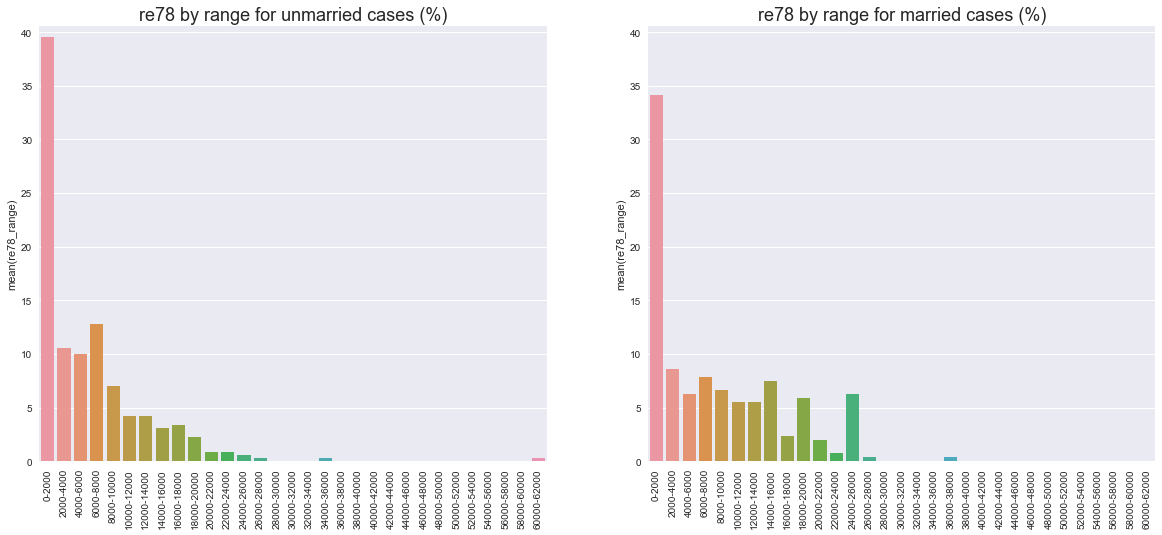

In [407]:
# Plot repartition
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
y_unmarried = barplot_distrib(df_unmarried['re78_range'], labels, 're78 by range for unmarried cases (%)', ax = ax[0])
y_married = barplot_distrib(df_married['re78_range'], labels, 're78 by range for married cases (%)', ax = ax[1])

ax[0].set(ylim=(0, np.max([y_unmarried, y_married])+1));
ax[1].set(ylim=(0, np.max([y_unmarried, y_married])+1));

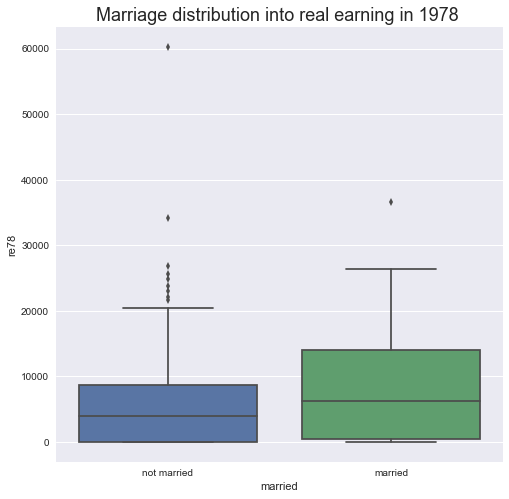

In [408]:
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.boxplot(x="married", y="re78", data=df_lalonde)
ax.set_xticklabels(["not married", "married"]);
ax.set_title('Marriage distribution into real earning in 1978 ', fontsize = 18);

**From the above plots, we notice that married individuals have high average earnings. However, not married indivuals boxplot analysis shows many more outliers but only two of them are really far above married upper fence. So an overall simple conclusion would be that married indiv. earns more. Maybe this is consequence of familiy duty or wife pressure...**

Now let's check if married people are more involved into taining:

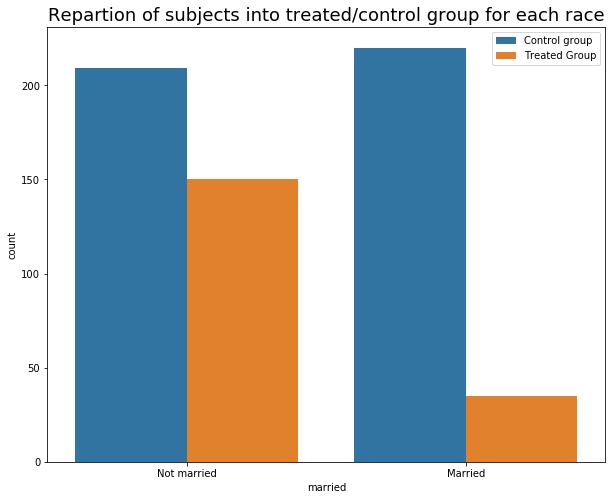

In [47]:
fig, ax = plt.subplots(1, 1,figsize = (10, 8))
sns.countplot(x = 'married', hue = 'treat', data = df_lalonde, ax = ax, order = [0,1])
ax.set_xticklabels(["Not married", "Married"])
ax.legend(["Control group", "Treated Group"])
ax.set_title("Repartion of subjects into treated/control group for each race", fontsize = 18);

**We notice that for control group, there are almost the same number of married and unmarried people. However, in treated group there are way more unmarried people. To sum up individuals married have better earnings but are less involved in trainings. As usual in this analysis, we need to pay attention to number of sample. Indeed, in this study there are less married people than unmarried.**

- **nodegree**

In [410]:
# Divide dataset into degree and not degree
df_degree = df_lalonde[df_lalonde['nodegree'] == 1]
print("Number of subjects with degree: {}".format(df_degree.shape[0]))

df_nodegree = df_lalonde[df_lalonde['nodegree'] == 1]
print("Number of subjects with not degree: {}".format(df_unmarried.shape[0]))


print("\nDescription real earning in 1978 for subjects with no degree:")
print(df_nodegree['re78'].describe())

print("\nDescription real earning in 1978 for subjects with degree:")
print(df_degree['re78'].describe())

Number of subjects with degree: 387
Number of subjects with not degree: 359

Description real earning in 1978 for subjects with no degree:
count      387.000000
mean      5978.633766
std       6930.918985
min          0.000000
25%         74.625190
50%       4112.513000
75%       9223.969500
max      60307.930000
Name: re78, dtype: float64

Description real earning in 1978 for subjects with degree:
count      387.000000
mean      5978.633766
std       6930.918985
min          0.000000
25%         74.625190
50%       4112.513000
75%       9223.969500
max      60307.930000
Name: re78, dtype: float64


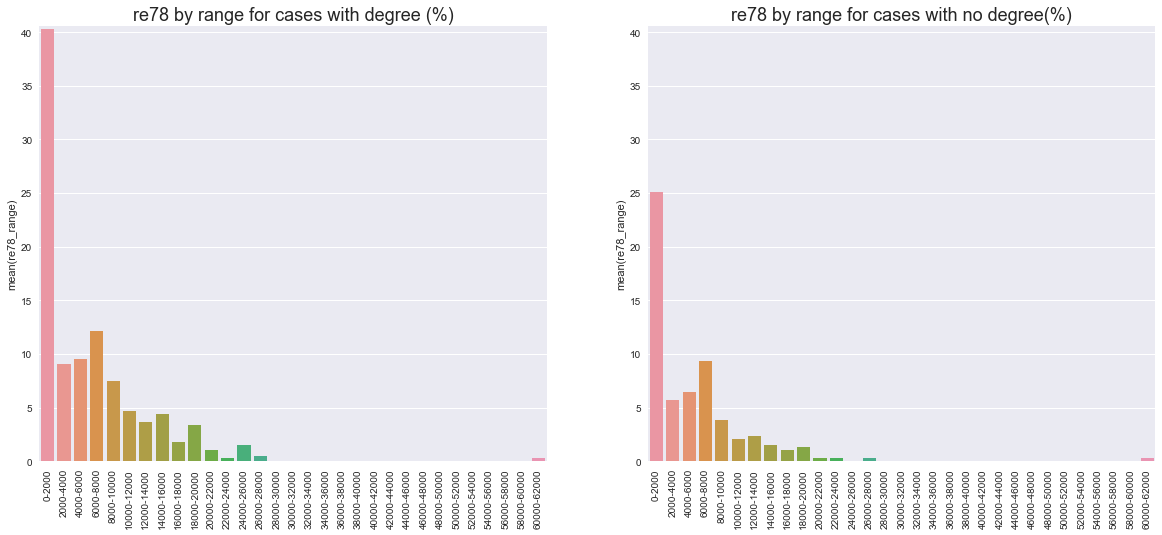

In [411]:
# Divide by re78 ranges in a new feature
df_degree['re78_range'] = pd.cut(df_degree['re78'], bins = bins, labels = labels)
df_nodegree['re78_range'] = pd.cut(df_unmarried['re78'], bins = bins, labels = labels)

# Plot repartition
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
y_degree = barplot_distrib(df_degree['re78_range'], labels, 're78 by range for cases with degree (%)', ax = ax[0])
y_nodegree = barplot_distrib(df_nodegree['re78_range'], labels, 're78 by range for cases with no degree(%)', ax = ax[1])

ax[0].set(ylim=(0, np.max([y_unmarried, y_married])+1));
ax[1].set(ylim=(0, np.max([y_unmarried, y_married])+1));

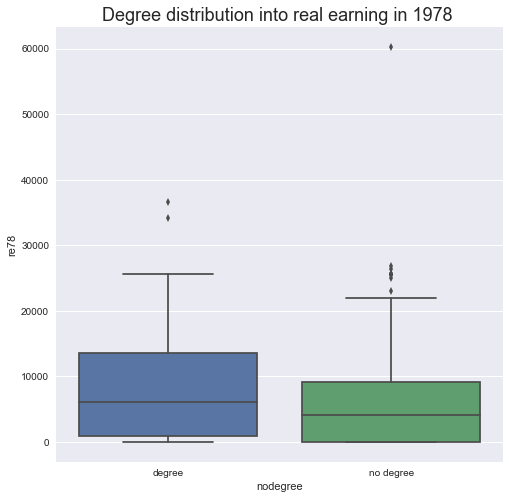

In [412]:
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.boxplot(x="nodegree", y="re78", data=df_lalonde)
ax.set_xticklabels(["degree", "no degree"]);
ax.set_title('Degree distribution into real earning in 1978 ', fontsize = 18);

** We notice from the above plots that, as one would expect, having a degree gets you better earnings. Nevertheless, we also observe an exceptionnal outlier among no degrees. Maybe a self made man who made (tiny) fortune :)**

Now let's have a look to nodegree distribution into the two groups:

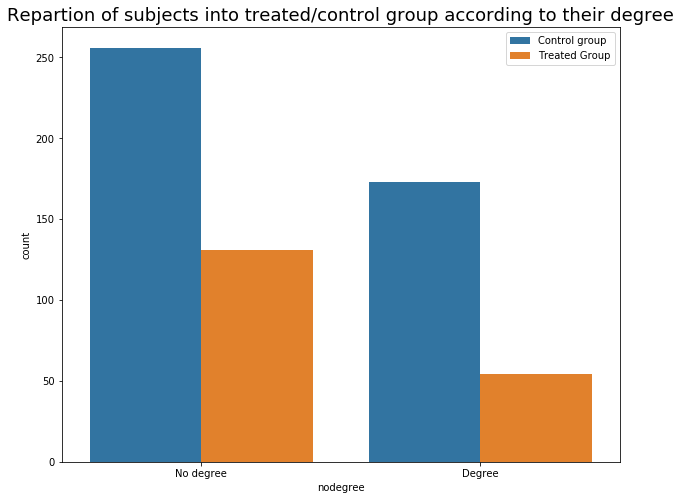

In [48]:
fig, ax = plt.subplots(1, 1,figsize = (10, 8))
sns.countplot(x = 'nodegree', hue = 'treat', data = df_lalonde, ax = ax, order = [1, 0])
ax.set_xticklabels(["No degree","Degree"])
ax.legend(["Control group", "Treated Group"])
ax.set_title("Repartion of subjects into treated/control group according to their degree", fontsize = 18);

**We notice again that distribution is not the same between people with degrees and people without degree.**

- **education**

In [414]:
df_lalonde['educ'].describe()

count    614.000000
mean      10.268730
std        2.628325
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64

For this feature, we won't observe the distribution for each possible number of years of education, as there are 18 possibilities (from 0 to 18 years). However, we take a look at the repartition of the subjects according to their number of years of education.

We see in the description above, that most of the cases received between 9 (lower quartile) and 12 (upper quartile) years of education. We confirm this by looking at the repartition of subjects according to their number of years of education.

In [415]:
# Repartition according to the number of years of studies
for num_years in df_lalonde['educ'].sort_values().unique():
    num_subjects = df_lalonde[df_lalonde['educ'] == num_years].shape[0]
    print('Number of subject who had {} years of education: {}'.format(num_years, num_subjects))

Number of subject who had 0 years of education: 3
Number of subject who had 1 years of education: 2
Number of subject who had 2 years of education: 2
Number of subject who had 3 years of education: 5
Number of subject who had 4 years of education: 9
Number of subject who had 5 years of education: 12
Number of subject who had 6 years of education: 12
Number of subject who had 7 years of education: 27
Number of subject who had 8 years of education: 62
Number of subject who had 9 years of education: 71
Number of subject who had 10 years of education: 87
Number of subject who had 11 years of education: 95
Number of subject who had 12 years of education: 157
Number of subject who had 13 years of education: 27
Number of subject who had 14 years of education: 21
Number of subject who had 15 years of education: 10
Number of subject who had 16 years of education: 8
Number of subject who had 17 years of education: 2
Number of subject who had 18 years of education: 2


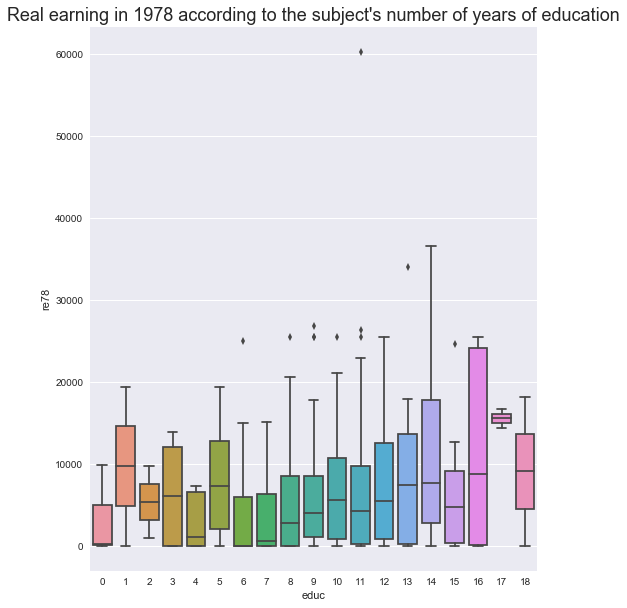

In [416]:
fig, ax = plt.subplots(figsize = (8,10))
ax = sns.boxplot(x="educ", y="re78", data=df_lalonde)
ax.set_title('Real earning in 1978 according to the subject\'s number of years of education', fontsize = 18);

**It is tough to interpret those boxplot for a number of years less than 5 and more than 16. Indeed, there is not enough cases in those classes to have a good insight.**

**Education does not really seem to be a really relevant factor for better earnings.**

Now let's check education distribution into the two groups:

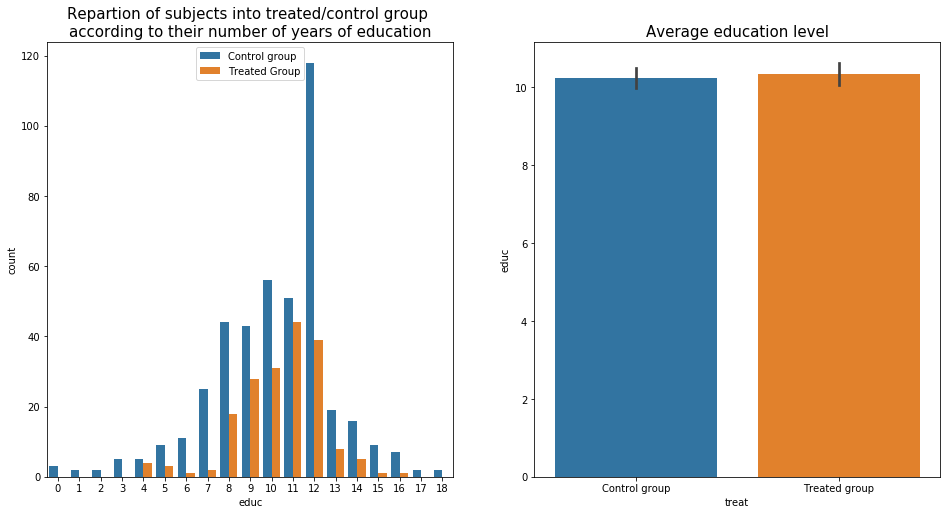

In [55]:
fig, ax = plt.subplots(1, 2,figsize = (16, 8))

sns.countplot(x = 'educ', hue = 'treat', data = df_lalonde, ax = ax[0])
ax[0].set_xticklabels(df_lalonde['educ'].sort_values().unique())
ax[0].legend(["Control group", "Treated Group"])
ax[0].set_title("Repartion of subjects into treated/control group \naccording to their number of years of education", fontsize = 15);


sns.barplot(x = 'treat', y = 'educ', data = df_lalonde, ax = ax[1])
ax[1].set_title('Average education level', fontsize = 15)
ax[1].set_xticklabels(["Control group", "Treated group"]);


**We notice that average level of education is close into the two groups. Nevertheless, we see that distribution of control group is always higher than treated distribution.**

### From this first analysis, it appears that a comparison between the two groups is difficult because of features distribution are clearly not the same. We need to adapt the dataset in term of distribution to perform a meaningful analysis. Using propensity score as following is a way to obtain a new dataset more suitable to a proper analysis###





#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

___

Let's build our logistic regression model, to determine the propensity score of a subject. As the **propensity score** is the probability of receiving the treatment, we will try to fit the `treat` feature
- Input features are `age`, `educ`, `married`, `nodegree`, `re74`, `re75`, `race`, which represent pre-treatement features
- Target feature is `treat`

In [418]:
logistic = linear_model.LogisticRegression()

# Prepare data for logistic regression
X = df_lalonde[['age', 'educ', 'married', 'nodegree', 're74', 're75', 'race']] 
y = np.ravel(df_lalonde[['treat']])

# Train model
logistic_fit = logistic.fit(X,y)

We do not want to predict the probability of being treated for a subject. However, we simulate it for the 3 first subjects of our dataset, to see it works well. We could also create new input features.

In [419]:
# Probability of each prediction for the first 3 subjects 
proba_treated = logistic_fit.predict_proba(X)
df=df_lalonde
# Proprensity score is the probability to be treated, i.e. probability `treat` to be 1
propensity_score = [elem[1] for elem in proba_treated]
for ind, pp_score in enumerate(propensity_score):
    df.loc[ind, 'propensity_score'] = pp_score
#for ind, pp_score in enumerate(propensity_score):
    #print("Propensity score for case {}: {}".format(ind, pp_score))

In [420]:
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.0,0.618047
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1.0,0.295794
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.0,0.696012
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.0,0.706712
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.0,0.662210


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

___

**We want to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. We need to use One-to-One pair matching without
replacement to respect these conditons.**

We update our subset treated and untreated, for them to have the race feature. For the record `0: Black`, `1: Hispan`, `2: White`.

In [421]:
df_treated = df[df['treat'] == 1]
df_untreated = df[df['treat'] == 0]

In [422]:
df_untreated.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race,propensity_score
185,PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67,2.0,0.025195
186,PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67,2.0,0.016263
187,PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67,2.0,0.019732
188,PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01,2.0,0.020840
189,PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00,0.0,0.424077


In [423]:
df_treated.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.0,0.618047
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1.0,0.295794
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.0,0.696012
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.0,0.706712
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.0,0.662210


In order to lead an acceptable study, we would like as much as possible to match a treated subject to an untreated one. Matched subjects are paired, if we can qualify them as "similar", meaning they have similar observed covariates. 

Of course, two subjects cannot be completely similar as there are a lot of unoberserved covariates that we don't have access to. However, the propensity score is based on these observed covariates (`age`, `educ`, `married`, `nodegree`, `re74`, `re75`, `race`).

Hence, two subjects are paired, if they were similarly likely to be treated, i.e. they have similar propensity score.

We see that some propoensity score are really close. We need to elect weither we use :
    - Nearest neighbor matching: 
selects for matching to a given treated subject that untreated subject whose propensity score is closest to that of the treated subject. If multiple untreated subjects have propensity scores that are equally close to that of the treated subject, one of these untreated subjects is selected at random.
or
    - Nearest neighbor matching with caliper:
similar to nearest neighbor matching with the further restriction that the absolute difference in the propensity scores of matched subjects must be below some prespecified threshold (the caliper distance). Thus, for a given treated subject, one would identify all the untreated subjects whose propensity score lay within a specified
distance of that of the treated subject. From this restricted set of untreated subjects, the untreated subject whose propensity score was closest to that of the treated subject would be selected for matching to this treated subject. If no untreated subjects had propensity scores that lay within the specified caliper distance of the propensity score of the treated subject, that treated subject would not be matched with any untreated subject. The unmatched treated subject would then be excluded from the resultant matched sample.

**Here we will used through networkx package Nearest neighbor matching with caliper in order to minimize the mean squared error of the estimated treatment effect in several scenarios.**

Source : https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view

To do so, we will use the `networkx` package, available with Python. 

We first build a bipartite graph to create all (id_treated,id_control) possible pairs.

In [424]:
from networkx.algorithms import bipartite

MySweetBabyMatch = nx.complete_bipartite_graph(df_treated.shape[0], df_untreated.shape[0])
#Create the biaprtite graph from the two sub_dataset

And compute for each pair the absolute difference of propensity score.

In [425]:
values = {}
for edge in MySweetBabyMatch.edges():
        diff = df_treated.loc[edge[0]]['propensity_score'] - df_untreated_redindex.loc[edge[1]]['propensity_score']
        values[edge] = -abs(diff)

#values ##display key: values

From this dictionnary of values, we want to assign edge attributes to store the value of that property for each edge:

In [426]:
nx.set_edge_attributes(MySweetBabyMatch,'weight',values=values)

Eventually, the algorithm minimize this values and return a list of matched pairs.

In [427]:
match = nx.max_weight_matching(MySweetBabyMatch, maxcardinality=True)

We can now extract the new dataset from the old ones using the obtained keys:

In [428]:
matched_keys = list(match.keys())
matched_keys.sort()
df_matched=df.iloc[matched_keys]

And divide this new dataset into the two groups:

In [429]:
untreat_match = df_matched[df_matched['treat'] == 0]
treat_match = df_matched[df_matched['treat'] == 1]

Let's have a look to re78 distribution into this new dataset:

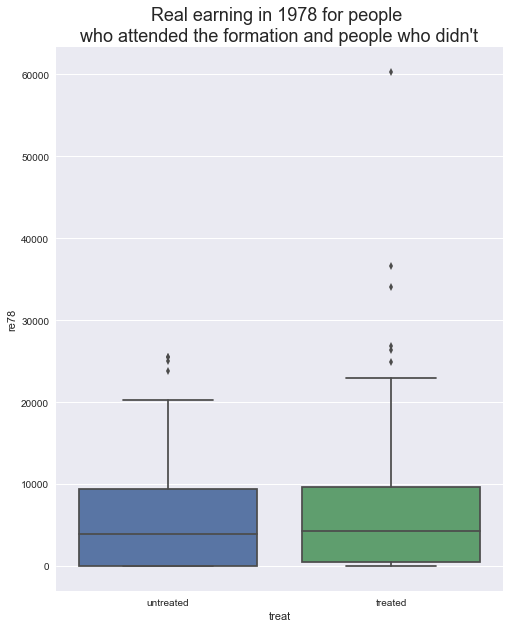

In [430]:
# Display barplot of real earning in '78 for matched dataset
fig, ax = plt.subplots(figsize = (8,10))
ax = sns.boxplot(x="treat", y="re78", data=df_matched)
ax.set_xticklabels(["untreated", "treated"]);
ax.set_title('Real earning in 1978 for people \nwho attended the formation and people who didn\'t', fontsize = 18);

**In this new plot, we see that the two boxplots results are inverted compared to our previous analysis. Indeed, here we see that treated people have higher median earnings, unlike our preivous results showing the inverse.**

Now let's display features distribution into the two groups but this time from the new dataset and compare them with the preivous results.

 **- Education**

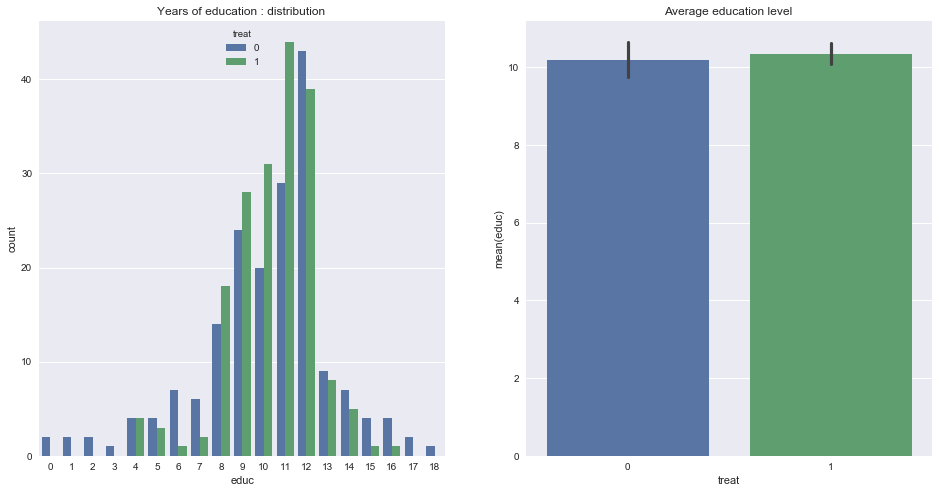

In [431]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize = (16, 8))

ax1.set_title('Years of education : distribution ')
ax2.set_title('Average education level ')

g1 = sns.countplot(hue = 'treat', x = 'educ', data = df_matched, ax = ax1)
g2 = sns.barplot(x = 'treat', y = 'educ', data = df_matched, ax = ax2)

 **- Degree**

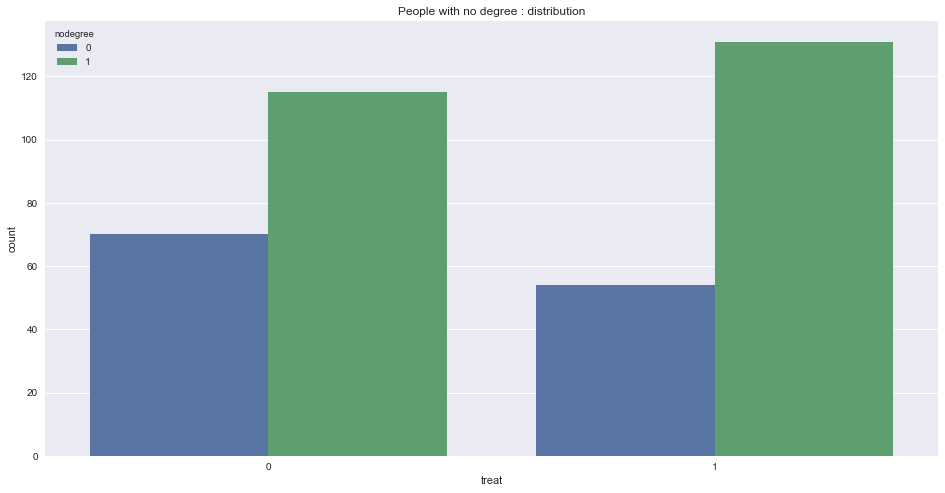

In [432]:
f, ax = plt.subplots(1, 1,figsize = (16, 8))
ax.set_title('People with no degree : distribution')
g = sns.countplot(x = 'treat', hue = 'nodegree', data = df_matched, ax = ax)

 **- Married**

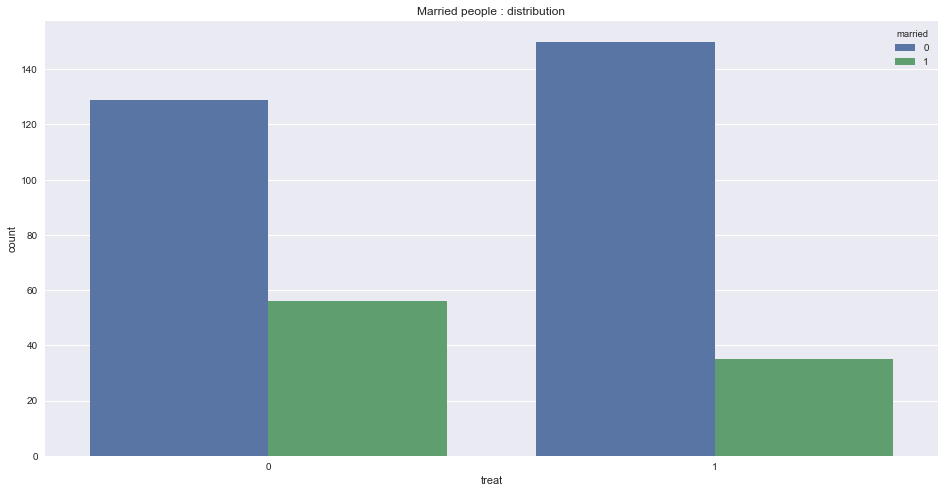

In [433]:
f, ax = plt.subplots(1, 1,figsize = (16, 8))
ax.set_title('Married people : distribution')
g = sns.countplot(x = 'treat', hue = 'married', data = df_matched, ax = ax)

 **- Origin**

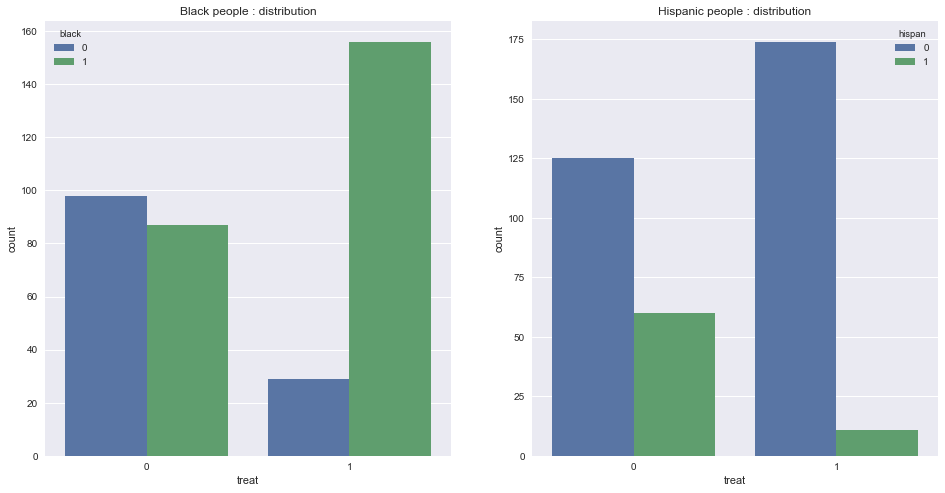

In [434]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize = (16, 8))

ax1.set_title('Black people : distribution')
ax2.set_title('Hispanic people : distribution')
g1 = sns.countplot(x = 'treat', hue = 'black', data = df_matched, ax = ax1)
g2 = sns.countplot(x = 'treat', hue = 'hispan', data = df_matched, ax = ax2)

**Distribution issues before matching have beeen partially adressed. We managed to get decent results for degrees, mariage and education but when we look at origins we see that there is still some work to do although matching has improved distribution into the control group. Matching need to be focused now on origins.**

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.



#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?



_____

### Question 2
_____

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

## Part 1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


**1- Import the dataset**<br>
The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. We have decided to fetch the raw data without any prior processing to get a true overview of what our random forest classifier can achieve and eventually see how it can be affected by the lack of data pre-processing.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all')

**2- Separate the input data from the target data**

In [ ]:
newsgroups_data = newsgroups.data
newsgroups_target = newsgroups.target

**3- Vectorize the input data**<br>
In order to feed predictive or clustering models with the text data, one first need to turn the text into vectors of numerical values suitable for statistical analysis. This can be achieved with the utilities of the sklearn.feature_extraction.text as demonstrated in the following example that extract TF-IDF vectors of unigram tokens from a subset of 20news. For the record, TF-IDF (short for term frequency-inverse document frequency) is of great help when it comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_data = TfidfVectorizer()
newsgroups_data_vectors = vectorizer_data.fit_transform(newsgroups_data)

**4- Split the data into a training and a validation (testing) set**<br>
90% of the dataset is used for training our random forest classifier, 10% is used to validate the different parameters tried on the model. These 10% are also used as testing data to test our final model.

In [ ]:
newsgroups_data_tr,newsgroups_data_te,newsgroups_target_tr,newsgroups_target_te = train_test_split(newsgroups_data_vectors,newsgroups_target, test_size=0.1, random_state=42)

## Part 2

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

**1- Train a random forest on the training set**<br>
In this first step, we use the default parameters of the RandomForestClassifier except for the *n_jobs* parameter which we set to the number of cores to speed the computation during the fitting process.

In [ ]:
clf = RandomForestClassifier(n_estimators = 10, max_depth = None, random_state = 84, n_jobs=-1)

Here, we fit the model using the training data. 

In [ ]:
clf.fit(newsgroups_data_tr,newsgroups_target_tr)

Now, we predict the classes of our test data using the previously fitted classifier. 

In [ ]:
newsgroups_target_te_pred = clf.predict(newsgroups_data_te)

And we calculate the accuracy score which consists in calculating the amount of classes correctly assigned to the test data by the classifier.

In [ ]:
acc_score = accuracy_score(newsgroups_target_te, newsgroups_target_te_pred)
acc_score

The use of this default random forest classifier shows that the assigned parameters does not provide a good classification of our data. We will now work on the fine-tuning of essential parameters which are : the number of estimators i.e. the number of trees in the forest and the maximum depth of the trees i.e. how far can a leave extend itself.

**2- Fine-tune the parameters of the random forest predictor on the validation set using a simple grid search on the number of estimators *n_estimators* and the max depth of the trees *max_depth***

**Random forest algorithm recap:**<br>
This algorithm consists in splitting the dataset into multiple subsets which will each train a separate model and in turn be split into again multiple subsets which will also train their own model. And so on, until the last leaves! After this forest is built, given "fresh" data i.e. testing data, each trained model gives its class assignment which is taken as a vote for this particular class and the finally assigned class is the one with the highest number of votes within all the models of the forest. <br>
This gives us an overview of the parameters that are essential to this algorithm which answer the following questions:
- Into how many subsets can I split my training dataset?
- How deep can I go into splitting the subsets recursively?

First question is monitored by the number of estimators which are the number of trees. Second question is supervised by the maximum depth of the trees.

To fine-tune these parameters we will follow the following procedure :
- Set a parameter grid by choosing a range of values for *n_estimators* and *max_depth*.
- Perform grid search algorithm with the previous chosen values to evaluate the performance of our random forest classifier.
- Once we have fitted our classifier on the training data with a pair of parameters from the grid, we predict the classes of our test data and calculate the related accuracy score to evaluate the performance ouf our random forest classifier with this set of parameters.

The below function performs these two last steps after having received the ranges of values for *n_estimators* and *max_depth* as well as the training and testing datasets. It returns an array composed of the accuracy scores.


In [ ]:
def grid_search(x_tr, y_tr, x_te, y_te, n_estimators_values, max_depth_values):
    scores = np.zeros((len(n_estimators_values), len(max_depth_values)))
    for i, n_estimators_value in enumerate(n_estimators_values):
        for j, max_depth_value in enumerate(max_depth_values):
            clf = RandomForestClassifier(n_estimators = n_estimators_value, max_depth = max_depth_value, random_state = 84, n_jobs=-1)
            clf.fit(x_tr,y_tr)
            
            y_te_pred = clf.predict(x_te)
            scores[i,j] = accuracy_score(y_te, y_te_pred)
    return scores

Here, we choose high values of *n_estimators* because the bigger the forest is the better the classifier will perform with very few risks of overfitting. However, we can not chose too high of a value because of time computation. But our results show that the more trees we have the more the scores increase. As for the *max_depth* parameter, we have previously noticed that a good range of values is around 100. The scores decrease with higher values of maximum depth for the trees. Limiting the maximum depth of a tree is also good to prevent our classifier from overfitting.

In [ ]:
n_estimators_values = np.arange(500,1600,500)
max_depth_values = np.arange(10,200,50)
scores = grid_search(newsgroups_data_tr, newsgroups_target_tr, newsgroups_data_te, newsgroups_target_te, n_estimators_values, max_depth_values)

Afterwards, we retrieve the index of the maximum accuracy score from the returned array to infer the optimal parameters.

In [ ]:
indOfMax = np.where(scores == np.max(scores))
if indOfMax[0].size > 1 :
    indOfMax = indOfMax[0][-1], indOfMax[1][-1]

In [ ]:
best_n_estimators = n_estimators_values[np.asscalar(indOfMax[0])]
best_max_depth = max_depth_values[np.asscalar(indOfMax[1])]
print('Best values for parameters among grid search are:\n','accuracy_score_max =',np.max(scores),'\n','n_estimators =',best_n_estimators,'\n','max_depth =',best_max_depth)

On the below figure, you can assess the areas of maximum accuracy score in regard of the parameters *n_estimators* and *max_depth*. Indeed, we see that the higher the values of number of trees and maximum depth of trees are the better the accuracy score is. Which is perfectly logical in the sense that the more classifiers you train the better the predictions will be. We see on the below representation that the rise in accuracy goes in the way of high values of both number of estimators and maximum depth. Nevertheless, we see that there is few variation along the maximum depth parameter in this range of values. Thus, we can offer to choose the lower value in this range to reduce time of computation and prevent from overfitting.

In [ ]:
X,Y = meshgrid(n_estimators_values, max_depth_values)
Z = scores
im = imshow(Z,cmap=cm.RdBu,extent=[np.min(n_estimators_values), np.max(n_estimators_values), np.min(max_depth_values), np.max(max_depth_values)],aspect='auto',interpolation='bilinear')

plt.colorbar(im)
plt.title('Accuracy score function of n_estimators and max_depth\n')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

In [ ]:
Learning from our grid search analysis, we now know that a very high value of number of trees is needed to have a good classifier. Thus, we will choose n_estimators = 1000. As for the maximum depth of the trees, we will select max_depth = 160 which gave out the highest score in our above analysis. 

In [ ]:
final_clf = RandomForestClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, random_state = 84, n_jobs=-1)

Then, we fit our model using the training dataset.

In [ ]:
newsgroups_target_te_pred = final_clf.fit(newsgroups_data_tr,newsgroups_target_tr).predict(newsgroups_data_te)

And further compute the accuracy score by submitting the testing data to the classifier.

In [ ]:
final_acc_score = accuracy_score(newsgroups_target_te, newsgroups_target_te_pred)
final_acc_score

**3- Display a confusion matrix of the classification pipeline**<br>
Computing a confusion matrix enables to evaluate the accuracy of a classification.
The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions. You can normalize this matrix by dividing theses numbers by the number of elements in each class.<br><br>
In the below code, we display our optimal random forest classifier confusion matrix both non normalized and normalized. 

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
    
    width = 12
    height = 12
    plt.figure(figsize=(width, height))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Retrieve class names from newsgroups data
class_names = newsgroups.target_names

# Compute confusion matrix
cnf_matrix = confusion_matrix(newsgroups_target_te, newsgroups_target_te_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

These two matrix provides us with several information:
- First, we can aknowledge that the optimal chosen classifier does a reasonnably good job by correctly retreiving the classes of each newsgroups piece of data. Indeed, the values on the diagonal in both matrix are among the highest ones.
- We encounter few classes that have lower scores such as 'sci.electronics' or 'talk.religion.misc'. Interesting fact with the latter is that it has a significant score of misclassified values as belonging to the 'sci.religion.christian' class which makes sense since these two labels are closely related. 
- We can observe several other acceptable misclassifications as for the following class: 'comp.os.ms-windows.misc' misclassified for 'comp.sys.obm.hardware' which can both relate closely in some conversation.

**4- Feature importances**

Before ending our analysis on this random forest classifier performance, we will look into the feature importances. A single line of code gives out an array of values representing the importance of a feature by a number: the bigger it is, the more important the feature is. 

In [ ]:
feature_importances_rf = final_clf.feature_importances_
feature_importances_rf.max()

The value of the maximum in this feature importances related array shows that there is no specifically predominant feature associated to the dataset. We will now sort this array to have an overview of how many features really matter. We will thus further display a curve representing the feature importances. 

In [ ]:
feature_importances_rf_sorted = np.sort(feature_importances_rf)[::-1]

In [ ]:
plt.plot(range(len(feature_importances_rf_sorted)), feature_importances_rf_sorted, 'ro')
plt.xlabel('indices')
plt.ylabel('feature_importances')
plt.title('Sorted Feature Importances')
plt.show()

The above curve speaks for itself as well as the number of 0-importance features, only a small amount of features within this huge array are really essential to the training of the classifier. Indeed, we can assume that all the data contained in the headers, footers or even in quotes are not relevant for our analysis and thus could be withdrawn from our training data features. This will lower the computational cost as well as increase the accuracy of the classifier as it will focus on training meaningful features.